In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
os.chdir('/content/drive/My Drive/ProyectoIA2/generative-spectral-datasets')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from models.main import make_encoder, make_generator, make_discriminator, spectralGAN, spectralGen
from models.utils import discriminator_loss, autoencoder_loss
from models.metrics import PSNR, SSIM
from data import load_dataset

import matplotlib.pyplot as plt

input_shape = (512,512,31)

In [3]:
BATCH_SIZE = 1

train_params = dict(
    batch_size = BATCH_SIZE,
    shuffle = True,
    cache = True
)

test_params = dict(
    batch_size = BATCH_SIZE,
    cache = True
)

_ , test_ds = load_dataset( train_params = train_params, test_params = test_params)

In [4]:
FACTOR = [ 1 , 1 , 1/2 , 1/2 , 1/4, 1/8]
features= 64

encoder = make_encoder(input_shape, features=features, factors=FACTOR)
generator = make_generator(input_shape, features=features, factors=FACTOR)
discriminator = make_discriminator(input_shape)

In [5]:
encoder.summary()
generator.summary()
discriminator.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 31)]    0         
_________________________________________________________________
encoder (Encoder)            (None, 512, 512, 8)       59184     
Total params: 59,184
Trainable params: 59,184
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 8)]     0         
_________________________________________________________________
generator (Generator)        (None, 512, 512, 31)      59230     
Total params: 59,230
Trainable params: 59,230
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

model = spectralGAN(encoder=encoder, generator=generator, discriminator=discriminator)

model.compile(
    a_optimizer = tf.keras.optimizers.Adam(1e-4),
    d_optimizer = tf.keras.optimizers.Adam(1e-4),
    a_loss = autoencoder_loss,
    d_loss = discriminator_loss,
    metrics = [ PSNR() ]
)


x0 = tf.constant(0. , shape=(1,) + input_shape)
model.__call__(x0)
model.load_weights('spectralGAN.h5')

In [7]:
metrics = model.evaluate(test_ds)

3/3 [==============================] - 2s 438ms/step - a_loss: -4.6938e-05 - d_loss: 1.3965 - psnr: 40.8676 - real_acc: 0.4633 - fake_acc: 0.6224


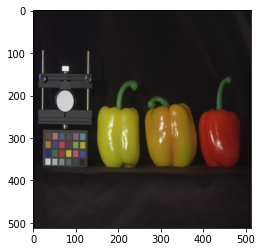

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


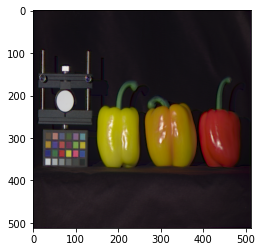

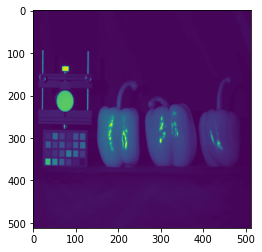

In [8]:
sample = next(iter(test_ds))
target = tf.reduce_mean( sample, axis=-1, keepdims=True)

alpha = encoder.predict(sample)
generated = generator.predict(alpha)

num = 0
RGB = [ 24, 15 , 5]

x_true = np.power( sample, 0.5 )
x_pred = np.power( generated, 0.5 )

plt.imshow(x_true[num][:,:,RGB])
plt.show()

plt.imshow(x_pred[num][:,:,RGB])
plt.show()

plt.imshow(target[0, : ,:, 0])
plt.show()


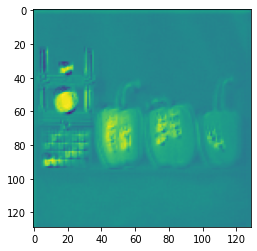

In [9]:
optimizer = tf.keras.optimizers.Adam(5e-2)

model_gen = spectralGen(generator=generator, discriminator=discriminator)
model_gen.compile( optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

alpha0 = tf.ones( (1,512,512,8) )
y_true = tf.ones( (1,129,129,1 ) )


y_pred = model_gen.predict([alpha0, target])


# alpha_init = tf.tile( target, [1, 1, 1, 31])
# alpha_init = encoder( alpha_init)

# model_gen.alpha.set_weights([alpha_init[0]])

# model_gen.alpha.set_weights([alpha0[0]])

plt.imshow(y_pred[0,:,:,0] )

In [10]:
model_gen.summary()

Model: "spectralGen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_layer (encodedLayer) multiple                  2097152   
_________________________________________________________________
generator (Functional)       (None, 512, 512, 31)      59230     
_________________________________________________________________
discriminator (Functional)   (None, 129, 129, 1)       166913    
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 2,323,295
Trainable params: 2,097,152
Non-trainable params: 226,143
_________________________________________________________________


In [11]:
model_gen.fit( x=[alpha0, target], y = y_true , epochs=2000  )

Epoch 1/2000
1/1 [==============================] - 3s 3s/step - loss: 1.7443 - accuracy: 0.9919
Epoch 2/2000
1/1 [==============================] - 0s 125ms/step - loss: 2.1565 - accuracy: 0.1571
Epoch 3/2000
1/1 [==============================] - 0s 136ms/step - loss: 1.5021 - accuracy: 0.9596
Epoch 4/2000
1/1 [==============================] - 0s 133ms/step - loss: 1.1427 - accuracy: 1.0000
Epoch 5/2000
1/1 [==============================] - 0s 127ms/step - loss: 0.9508 - accuracy: 1.0000
Epoch 6/2000
1/1 [==============================] - 0s 131ms/step - loss: 0.8142 - accuracy: 1.0000
Epoch 7/2000
1/1 [==============================] - 0s 134ms/step - loss: 0.7010 - accuracy: 1.0000
Epoch 8/2000
1/1 [==============================] - 0s 131ms/step - loss: 0.6040 - accuracy: 1.0000
Epoch 9/2000
1/1 [==============================] - 0s 129ms/step - loss: 0.5210 - accuracy: 1.0000
Epoch 10/2000
1/1 [==============================] - 0s 134ms/step - loss: 0.4508 - accuracy: 1.0000
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


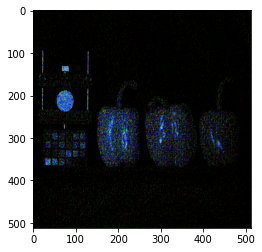

In [12]:
alpha = model_gen.alpha.get_weights()[0]
estimated = generator(alpha[None, :]).numpy()
plt.imshow(estimated[0][:,:, RGB])
plt.show()

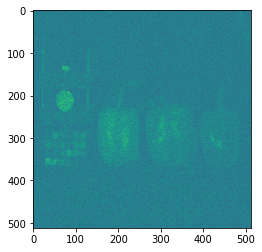

In [13]:
plt.imshow(alpha[ : ,:, 0])